In [1]:
import yaml
from utils import load_config  
import torch
from accelerate import Accelerator
from data_utils.build_dataset import build_id_dataloaders, build_ood_dataloaders,build_jigsaw_dataloaders
from data_utils.transforms import get_ood_transform,get_id_transform
from data_utils.ood_datasets import get_ood_dataset
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.utils as T


## 🔹 可视化函数（反归一化 + 显示）

In [2]:
def unnormalize(t,mean,std):
    # CIFAR10 mean/std
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return torch.clamp(t * std + mean, 0, 1)

def show_images(x, y,mean,std, n=16):
    x = x[:n]
    y = y[:n]
    x = torch.stack([unnormalize(img.cpu(),mean,std) for img in x])
    grid_img = transforms.ToPILImage()(T.make_grid(x, nrow=int(n**0.5)))
    plt.figure(figsize=(4,4))
    plt.imshow(grid_img)
    plt.axis("off")
    plt.title("Sample Images")
    plt.show()


## 🔹 加载配置 & Accelerator

In [3]:
cfg = load_config("../configs/default.yaml")
print(cfg['id_dataset'])

{'name': 'imagenet', 'root': '/Users/sunshine8641/Code/Data/'}


In [4]:
accelerator = Accelerator()


In [5]:
print("当前设备:", accelerator.device)  # 输出: device(type='cuda', index=0) 或 'cpu'
print("当前进程信息:")
print("是否是主进程:", accelerator.is_main_process)  # 主进程返回 True
print("进程总数:", accelerator.num_processes)      # 总 GPU/TPU 数量
print("当前进程 ID:", accelerator.process_index)   # 从 0 开始编号
print("混合精度类型:", accelerator.mixed_precision)  # 输出: 'no'/'fp16'/'bf16'
accelerator.print(f"完整设备状态:\n{accelerator.state}")


当前设备: mps
当前进程信息:
是否是主进程: True
进程总数: 1
当前进程 ID: 0
混合精度类型: no
完整设备状态:
Distributed environment: DistributedType.NO
Num processes: 1
Process index: 0
Local process index: 0
Device: mps

Mixed precision type: no



## 🔹 加载 ID 数据集并取一批

In [6]:
print(cfg["id_dataset"]["name"])

imagenet


In [7]:
id_train_loader,id_test_loader, id_val_loader = build_id_dataloaders(cfg, accelerator)

    

In [13]:
for batch in id_train_loader:
        x, y = batch
        print(f"ID Train Batch: x.shape={x.shape}, y.shape={y.shape}")
        break

for batch in id_val_loader:
        x, y = batch
        print(f"ID Val Batch: x.shape={x.shape}, y.shape={y.shape}")
        break

ID Train Batch: x.shape=torch.Size([128, 3, 224, 224]), y.shape=torch.Size([128])
ID Val Batch: x.shape=torch.Size([128, 3, 224, 224]), y.shape=torch.Size([128])


In [9]:
tr=get_id_transform(cfg['id_dataset']['name'])
for t in tr[0].transforms:
    if isinstance(t, transforms.Normalize):
        print("Mean:", t.mean)
        mean=t.mean
        print("Std:", t.std)
        std=t.std

Mean: [0.485, 0.456, 0.406]
Std: [0.229, 0.224, 0.225]


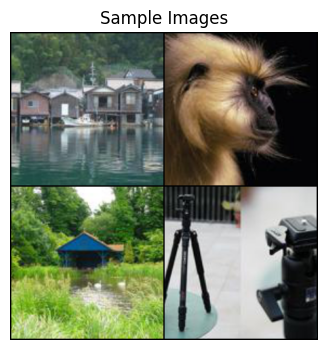

In [14]:
show_images(x, y,mean,std, n=4)

In [15]:
y

tensor([14, 12, 14,  6,  7, 29, 17, 19, 24, 29, 14,  5,  6,  0, 17,  7,  2, 23,
         4, 29, 18, 28, 16, 29, 21,  3,  7,  0, 23, 13, 17,  7,  4, 22, 24, 25,
        15,  6, 29,  0, 19,  1, 12,  9,  9, 23, 27, 13, 14, 29,  2,  1, 13, 12,
         6, 17,  7, 11, 20, 23, 21,  8, 13, 23,  4, 23, 29,  8, 19, 29, 21,  1,
        22, 26,  3, 17, 11, 27, 17, 14,  9, 20,  3, 27, 18, 24, 17, 15, 22, 21,
        23,  5, 17,  9, 28, 25,  9,  4, 10,  5, 19, 25,  3,  7, 25, 15, 16, 19,
        12,  8, 28, 13, 11, 29,  0, 27, 23, 19, 29, 15, 25, 12,  9,  7,  5,  0,
        15,  5])

## 🔹 加载 OOD 数据集

In [6]:
# cfg["ood_dataset"]["name"]="textures"
# cfg["ood_dataset"]["root"]

In [12]:
ood_name = cfg["ood_dataset"]["name"]
ood_root = cfg["ood_dataset"]["root"]

print(f"[Test] Loading OOD Dataloader for {ood_name}...")
ood_loader = build_ood_dataloaders(cfg, accelerator)
for batch in ood_loader:
    x, y = batch
    print(f"OOD Batch: x.shape={x.shape}")
    break

[Test] Loading OOD Dataloader for svhn...
OOD Batch: x.shape=torch.Size([128, 3, 32, 32])


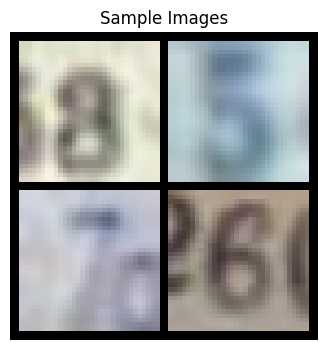

In [13]:
show_images(x, y,mean,std, n=4)

In [13]:
jigsaw_train_loader, jigsaw_test_loader,jigsaw_val_loader = build_jigsaw_dataloaders(cfg, accelerator)
for batch in jigsaw_train_loader:
        x, y = batch
        print(f"ID Train Batch: x.shape={x.shape}, y.shape={y.shape}")
        break

# for batch in jigsaw_val_loader:
#         x, y = batch
#         print(f"ID Val Batch: x.shape={x.shape}, y.shape={y.shape}")
#         break
    

ID Train Batch: x.shape=torch.Size([128, 3, 32, 32]), y.shape=torch.Size([128])


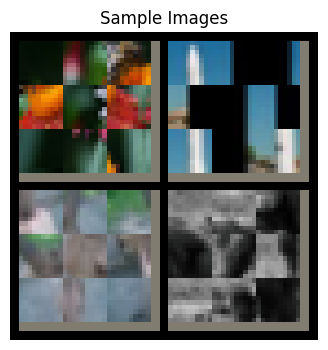

In [14]:
show_images(x, y,mean,std, n=4)

[Test] Loading OOD Dataloader for textures...
OOD Batch: x.shape=torch.Size([128, 3, 32, 32])


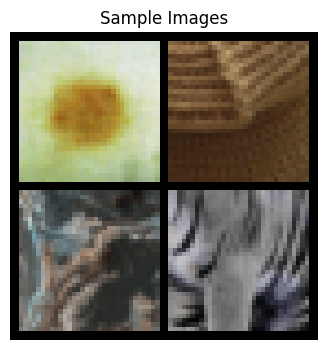

In [14]:
cfg["ood_dataset"]["name"]="textures"
ood_name = cfg["ood_dataset"]["name"]
ood_root = cfg["ood_dataset"]["root"]

print(f"[Test] Loading OOD Dataloader for {ood_name}...")
ood_loader = build_ood_dataloaders(cfg, accelerator)
for batch in ood_loader:
    x, y = batch
    print(f"OOD Batch: x.shape={x.shape}")
    break
show_images(x, y,mean,std, n=4)

[Test] Loading OOD Dataloader for LSUN_R...
/Users/sunshine8641/Code/Data/LSUN_R
OOD Batch: x.shape=torch.Size([128, 3, 32, 32])


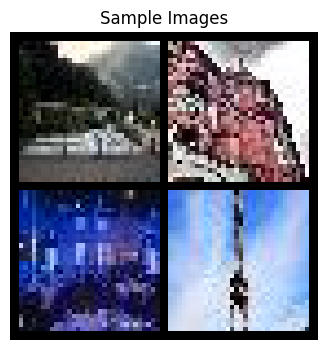

In [7]:
cfg["ood_dataset"]["name"]="LSUN_R"
ood_name = cfg["ood_dataset"]["name"]
ood_root = cfg["ood_dataset"]["root"]

print(f"[Test] Loading OOD Dataloader for {ood_name}...")
ood_loader = build_ood_dataloaders(cfg, accelerator)
for batch in ood_loader:
    x, y = batch
    print(f"OOD Batch: x.shape={x.shape}")
    break
show_images(x, y,mean,std, n=4)

[Test] Loading OOD Dataloader for LSUN_C...
/Users/sunshine8641/Code/Data/LSUN_C
OOD Batch: x.shape=torch.Size([128, 3, 32, 32])


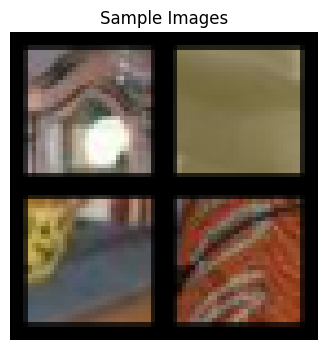

In [9]:
cfg["ood_dataset"]["name"]="LSUN_C"
ood_name = cfg["ood_dataset"]["name"]
ood_root = cfg["ood_dataset"]["root"]

print(f"[Test] Loading OOD Dataloader for {ood_name}...")
ood_loader = build_ood_dataloaders(cfg, accelerator)
for batch in ood_loader:
    x, y = batch
    print(f"OOD Batch: x.shape={x.shape}")
    break
show_images(x, y,mean,std, n=4)

[Test] Loading OOD Dataloader for iSUN...
/Users/sunshine8641/Code/Data/iSUN
OOD Batch: x.shape=torch.Size([128, 3, 32, 32])


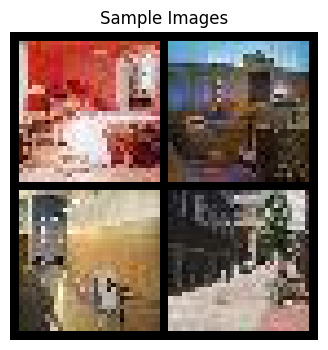

In [10]:
cfg["ood_dataset"]["name"]="iSUN"
ood_name = cfg["ood_dataset"]["name"]
ood_root = cfg["ood_dataset"]["root"]

print(f"[Test] Loading OOD Dataloader for {ood_name}...")
ood_loader = build_ood_dataloaders(cfg, accelerator)
for batch in ood_loader:
    x, y = batch
    print(f"OOD Batch: x.shape={x.shape}")
    break
show_images(x, y,mean,std, n=4)

[Test] Loading OOD Dataloader for iNaturalist...
/Users/sunshine8641/Code/Data/iNaturalist
OOD Batch: x.shape=torch.Size([128, 3, 32, 32])


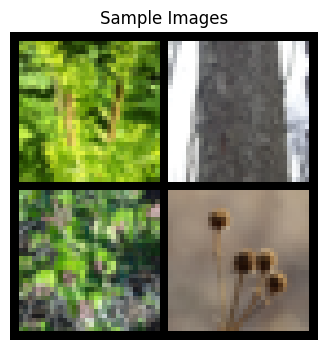

In [11]:
cfg["ood_dataset"]["name"]="iNaturalist"
ood_name = cfg["ood_dataset"]["name"]
ood_root = cfg["ood_dataset"]["root"]

print(f"[Test] Loading OOD Dataloader for {ood_name}...")
ood_loader = build_ood_dataloaders(cfg, accelerator)
for batch in ood_loader:
    x, y = batch
    print(f"OOD Batch: x.shape={x.shape}")
    break
show_images(x, y,mean,std, n=4)

[Test] Loading OOD Dataloader for SUN...
/Users/sunshine8641/Code/Data/SUN
OOD Batch: x.shape=torch.Size([128, 3, 32, 32])


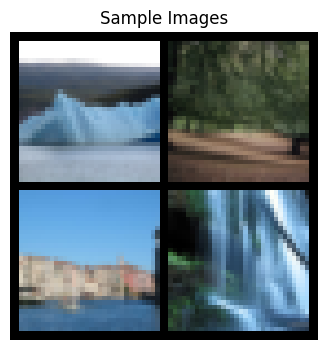

In [12]:
cfg["ood_dataset"]["name"]="SUN"
ood_name = cfg["ood_dataset"]["name"]
ood_root = cfg["ood_dataset"]["root"]

print(f"[Test] Loading OOD Dataloader for {ood_name}...")
ood_loader = build_ood_dataloaders(cfg, accelerator)
for batch in ood_loader:
    x, y = batch
    print(f"OOD Batch: x.shape={x.shape}")
    break
show_images(x, y,mean,std, n=4)

[Test] Loading OOD Dataloader for Places...
/Users/sunshine8641/Code/Data/Places
OOD Batch: x.shape=torch.Size([128, 3, 32, 32])


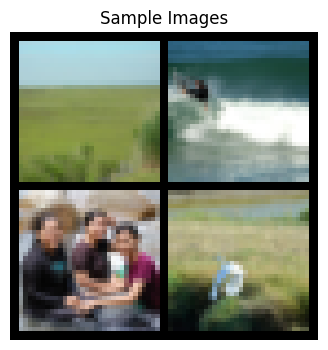

In [13]:
cfg["ood_dataset"]["name"]="Places"
ood_name = cfg["ood_dataset"]["name"]
ood_root = cfg["ood_dataset"]["root"]

print(f"[Test] Loading OOD Dataloader for {ood_name}...")
ood_loader = build_ood_dataloaders(cfg, accelerator)
for batch in ood_loader:
    x, y = batch
    print(f"OOD Batch: x.shape={x.shape}")
    break
show_images(x, y,mean,std, n=4)